In [1]:
from mylib.statistic_test import *

code_id = '0355 - Field Centroid Distribution'
loc = join(figpath, code_id)
mkdir(loc)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0355 - Field Centroid Distribution is already existed!


# Get Nearest ROI

In [2]:
# import cdist
from scipy.spatial.distance import cdist

def get_nearest_roi(sfp_dir):
    with h5py.File(sfp_dir, 'r') as f:
        sfp = np.array(f['SFP'])
    
    centroids = np.zeros((sfp.shape[2], 2), dtype=np.float64)
    for i in range(sfp.shape[2]):
        vmax = np.max(sfp[:, :, i])
        x, y = np.where(sfp[:, :, i] == vmax)
        centroids[i, 0] = x[0]
        centroids[i, 1] = y[0]
    
    dist_matrix = cdist(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)
    nearest_indices = np.argmin(dist_matrix, axis=1)
    return nearest_indices, dist_matrix[(np.arange(len(nearest_indices)), nearest_indices)]

for i in range(len(f_CellReg_modi)):
    continue
    if f_CellReg_modi['Type'][i] != 'Real':
        continue
    f = f_CellReg_modi

    line = i
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]
    
    index_map = GetMultidayIndexmap(
        mouse,
        stage=stage,
        session=session,
        i = i,
        occu_num=2
    )
    index_map[np.where((np.isnan(index_map))|(index_map < 0))] = 0

    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    print(f"{i}: {mouse} {behavior_paradigm} {maze_type}")
    for fi in tqdm(file_indices):
        with open(fdata['Trace File'][fi], 'rb') as handle:
            trace = pickle.load(handle)

        sfp_dir = join(f_CellReg_modi['sfp_folder'][i], f"SFP{int(fdata['date'][fi])}.mat")
        nearest_indices, distances = get_nearest_roi(sfp_dir)
        trace['nearest_roi'] = nearest_indices+1
        trace['nearest_roi_distances'] = distances
        #print(trace['RawTraces'].shape[0],fdata['Trace File'][fi],  sfp_dir)
        assert trace['n_neuron'] == len(nearest_indices), f"Number of ROIs does not match: {trace['n_neuron']} != {len(nearest_indices)}"

        with open(fdata['Trace File'][fi], 'wb') as handle:
            pickle.dump(trace, handle)

In [21]:
with open(f_CellReg_modi['Trace File'][8], 'rb') as handle:
    trace1 = pickle.load(handle)

pf_all = trace1['place_field_all']
index_map_piece = trace1['index_map'][0, :].astype(np.int64)
field_info = trace1['field_info']
for i in range(len(pf_all)):
    pf = pf_all[i][0]
    if isinstance(pf, dict):
        print(np.unique(np.asarray(list(pf.keys()))), np.unique(field_info[0, np.where(field_info[0, :, 0] == index_map_piece[i])[0], 2]))

[ 390  563  913 1292 1736] [ 390.  563.  913. 1292. 1736.   nan]
[ 188 1166 1481] [ 188. 1166. 1481.   nan]
[1339 1559] [1339. 1559.   nan]
[] [nan]
[ 132  283  390  554  563  714  780 1141 1356 1465 1531 1828 2106] [ 132.  283.  390.  554.  563.  714.  780. 1141. 1356. 1465. 1531. 1828.
 2106.   nan]
[ 284  365  392  776  890  955 1142 1358 1513 1926] [ 284.  365.  392.  776.  890.  955. 1142. 1358. 1513. 1926.   nan]
[ 328  871  888 1133 1198 1264 1334 1634] [ 328.  871.  888. 1133. 1198. 1264. 1334. 1634.   nan]
[  70  242  329  729 1090 1482 1645 1705 2108] [  70.  242.  329.  729. 1090. 1482. 1645. 1705. 2108.   nan]
[  21   91  155  274  403  666  913  951 1134 1158 1329 1484 1750 2025
 2150] [  21.   91.  155.  274.  403.  666.  913.  951. 1134. 1158. 1329. 1484.
 1750. 2025. 2150.   nan]
[ 137  201  241  408  754  950 1009 1109 1181 1293 1412 1611 1927 2106] [ 137.  201.  241.  408.  754.  950. 1009. 1109. 1181. 1293. 1412. 1611.
 1927. 2106.   nan]
[  10  193  421  455  757  9

# Get Field Centroid Distance

In [ ]:
def registered_fields_distribution(
    smooth_map_1: np.ndarray,
    smooth_map_2: np.ndarray,
    i: int,
    j: int, 
    place_field_all: list[dict],
    field_info: np.ndarray,
    field_reg: np.ndarray,
    index_map: np.ndarray,
    maze_type: int
):
    assert j > i, "j must be greater than i."
    center_i, center_j = [], []
    for n in range(len(place_field_all)):
        pf_i, pf_j = place_field_all[n][i], place_field_all[n][j]
        if isinstance(pf_i, dict) and isinstance(pf_j, dict):
            idx_i = np.where(
                (field_info[i, :, 0] == index_map[i, n]) &
                (field_reg[i, :] == 1) &
                (field_reg[j, :] == 1)
            )[0]
            idx_j = np.where(
                (field_info[j, :, 0] == index_map[j, n]) &
                (field_reg[j, :] == 1) &
                (field_reg[i, :] == 1)
            )[0]
            idx_i = idx_j = np.intersect1d(idx_i, idx_j)
            if len(idx_i) > 0:
                for idx in idx_i:
                    if np.isnan(field_info[i, idx, 2]) or np.isnan(field_info[j, idx, 2]):
                        raise ValueError("Field center is NaN.")
                    center_processed = int(field_info[i, idx, 2])
                    try:
                        field_region = np.asarray(pf_i[center_processed], np.int64)
                    except:
                        continue
                    cell_i = int(field_info[i, idx, 0])
                    cell_j = int(field_info[j, idx, 0])

                    centroid_i = field_region[np.argmax(smooth_map_1[cell_i-1, field_region-1])]
                    centroid_j = field_region[np.argmax(smooth_map_2[cell_j-1, field_region-1])]

                    center_i.append(centroid_i)
                    center_j.append(centroid_j)

    centroid_i = np.asarray(center_i, np.int64)
    centroid_j = np.asarray(center_j, np.int64)
    
    D = GetDMatrices(maze_type, 48)
    return D[(centroid_i-1, centroid_j-1)].astype(np.float64)
    
def find_nearest_fields(
    fields_of_cellA: dict,
    fields_of_cellB: dict,
    maze_type: int
):
    D = GetDMatrices(maze_type, 48)
    centers_A = np.asarray(list(fields_of_cellA.keys()), np.int64)
    centers_B = np.asarray(list(fields_of_cellB.keys()), np.int64)

    dist_mat = D[np.ix_(centers_A-1, centers_B-1)]
    return np.min(dist_mat, axis=1)

def get_field_distance_between_nearby_rois(
    trace1: dict,
    trace2: dict,
    i: int,
    j: int,
    index_map: np.ndarray,
    maze_type: int,
    dirs: str = 'cis'
):
    """Get field distance between an ROI in S1 (trace1) and the nearest neighbor of its corresponding ROI in S2 (trace2)."""
    assert trace1['maze_type'] == trace2['maze_type'], "Maze types do not match."
    assert 'nearest_roi' in trace1.keys(), "Trace1 does not have nearest_roi."
    assert 'nearest_roi' in trace2.keys(), "Trace2 does not have nearest_roi."
    assert 'nearest_roi_distances' in trace1.keys(), "Trace1 does not have nearest_roi_distances."
    assert 'nearest_roi_distances' in trace2.keys(), "Trace2 does not have nearest_roi_distances."

    index_map = index_map.astype(np.int64)
    dist_mat = []

    try:
        place_field_all_i = trace1['place_field_all']
        place_field_all_j = trace2['place_field_all']
    except:
        place_field_all_i = trace1[dirs]['place_field_all']
        place_field_all_j = trace2[dirs]['place_field_all']

    cell_idx = np.where((index_map[i, :] > 0)&(index_map[j, :] > 0))[0]
    nearby_cells = np.random.permutation(np.arange(trace2['n_neuron']))#nearby_cells = trace2['nearest_roi']
    for n in cell_idx:
        cell_i = index_map[i, n]
        cell_j = nearby_cells[index_map[j, n] - 1]
        pf_i = place_field_all_i[cell_i-1]
        pf_j = place_field_all_j[cell_j-1]
        if isinstance(pf_i, dict) and isinstance(pf_j, dict):
            if len(pf_i.keys()) == 0 or len(pf_j.keys()) == 0:
                dist_mat.append(np.array([]))
                continue
            dist_ij = find_nearest_fields(pf_i, pf_j, maze_type)
            dist_mat.append(dist_ij)
        else:
            dist_mat.append(np.array([]))
    
    return np.concatenate(dist_mat)

def compute_centroid_distance_main(
    i: int,
    f: pd.DataFrame = f_CellReg_modi,
    save_dir: str = loc,
    dirs: str = 'cis',
    thre: float = 0.75
):
    if f['Type'][i] != 'Real':
        return
    
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]

    if behavior_paradigm == 'CrossMaze':
        paradm = 'MA' if maze_type == 1 else 'MB'
    elif behavior_paradigm == 'ReverseMaze':
        paradm = 'MAf' if dirs == 'cis' else 'MAb'
    elif behavior_paradigm == 'HairpinMaze':
        paradm = 'HPf' if dirs == 'cis' else 'HPb'

    if exists(join(save_dir, f"{i}_{mouse}_{paradm}.pkl")):
        return

    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    print(f"{i}: {mouse} {paradm} Thre {thre}   ---- {DateTime()}")
    traces = []
    for fi in tqdm(file_indices):
        with open(fdata['Trace File'][fi], 'rb') as handle:
            trace = pickle.load(handle)
        traces.append(trace)
    
    if paradm in ['MAf', 'MAb']:
        paradm_in_filename = 'MAf or MAb'
    elif paradm in ['HPf', 'HPb']:
        paradm_in_filename = 'HPf or HPb'
    else:
        paradm_in_filename = paradm

    mday_dir = f_CellReg_modi['Trace File'][i] if np.abs(thre-0.75) < 1e-2 else join(loc, "Diff_Threshold", f"THRE_{thre}_{i}_{mouse}_{paradm_in_filename}.pkl")
    with open(mday_dir, 'rb') as handle:
        trace_mdays = pickle.load(handle)
    
    res = {
        "MiceID": [],
        "Paradigm": [],
        "Field Distance": [],
        "Session i": [],
        "Session j": [],
        "Type": [],
        "Threshold": []
    }
    
    try:
        field_reg = trace_mdays['field_reg']
        field_info = trace_mdays['field_info']
        place_field_all = trace_mdays['place_field_all']
        index_map = trace_mdays['index_map']
    except:
        field_reg = trace_mdays[dirs]['field_reg']
        field_info = trace_mdays[dirs]['field_info']
        place_field_all = trace_mdays[dirs]['place_field_all']
        index_map = trace_mdays['index_map']

    for j in range(field_reg.shape[0]-1):
        for k in range(j+1, field_reg.shape[0]):
            # Get real distribution
            print(f"  Compute S{j+1}-{k+1}")
            try:
                dist_real = registered_fields_distribution(
                    traces[j]['smooth_map_all'],
                    traces[k]['smooth_map_all'],
                    j,
                    k,
                    place_field_all,
                    field_info,
                    field_reg,
                    index_map,
                    maze_type
                )
            except:
                dist_real = registered_fields_distribution(
                    traces[j][dirs]['smooth_map_all'],
                    traces[k][dirs]['smooth_map_all'],
                    j,
                    k,
                    place_field_all,
                    field_info,
                    field_reg,
                    index_map,
                    maze_type
                )
            
            dist_nearby = get_field_distance_between_nearby_rois(
                traces[j],
                traces[k],
                j,
                k,
                index_map=index_map,
                maze_type=maze_type,
                dirs=dirs
            )
            res['MiceID'].append(np.repeat(mouse, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Paradigm'].append(np.repeat(paradm, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Field Distance'].append(np.concatenate([dist_real, dist_nearby]))
            res['Type'].append(np.repeat('Real', dist_real.shape[0]))
            res['Type'].append(np.repeat('Nearby', dist_nearby.shape[0]))
            res['Session i'].append(np.repeat(j+1, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Session j'].append(np.repeat(k+1, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Threshold'].append(np.repeat(thre, dist_real.shape[0]+dist_nearby.shape[0]))
    
    for k in res.keys():
        res[k] = np.concatenate(res[k])
    
    if exists(save_dir) == False:
        os.makedirs(save_dir)
    with open(join(save_dir, f"{i}_{mouse}_{paradm}.pkl"), 'wb') as handle:
        pickle.dump(res, handle)
        
    idx_real = np.where(res['Type'] == 'Real')[0]
    idx_nearby = np.where(res['Type'] == 'Nearby')[0]
    y, x = np.histogram(res['Field Distance'][idx_real], bins=50, range=(0, 100), density=True)
    x = (x[1:]+x[:-1])/2
    y2, x2 = np.histogram(res['Field Distance'][idx_nearby], bins=50, range=(0, 100), density=True)
    x2 = (x2[1:]+x2[:-1])/2
    plt.figure(figsize=(4, 3))
    plt.plot(x, y, label='Real', linewidth=0.5, marker='o', markersize=3, markeredgewidth=0)
    plt.plot(x2, y2, label='Nearby', linewidth=0.5, marker='o', markersize=3, markeredgewidth=0)
    plt.legend()
    plt.xlim(-2, 102)
    plt.show()
    print(f"{DateTime()}    -- Done.", end='\n\n')
    return res

"""
for i in range(8, 7, -1):
    for thre in [0.8]:
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            compute_centroid_distance_main(i, thre=thre,save_dir=join(loc, f"Res Thre {thre}"))
        else:
            compute_centroid_distance_main(i, thre=thre, dirs='cis', save_dir=join(loc, f"Res Thre {thre}"))
            compute_centroid_distance_main(i, thre=thre, dirs='trs', save_dir=join(loc, f"Res Thre {thre}"))
"""
pass

# Get Distribution

100%|██████████| 44/44 [00:00<00:00, 281.13it/s]


6000
  Mean: 23.378247703915985, STD: 5.0140149176018465, Max: 32.2490309931942, Min: 17.23270614583668, Median: 21.282447995627674, df: 29


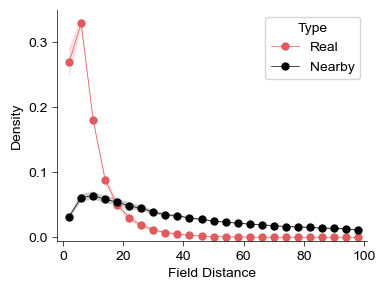

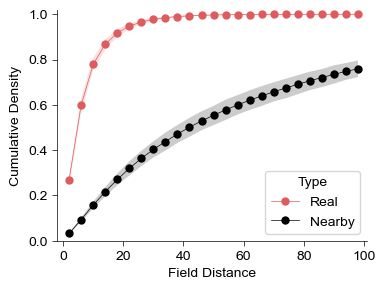

In [3]:
if exists(join(figdata, f" {code_id} [Distribution].pkl")) == False:
    CentroidDist = {
        "MiceID": [],
        "Paradigm": [],
        "Field Distance": [],
        "Density": [],
        "Cumulative Density": [],
        "Unique ID": [],
        "Type": [],
        "Threshold": []
    }
    uniq_id = 0
    for n, thre in enumerate([0.75, 0.5, 0.6, 0.8]):
        if n == 0:
            res_dir = loc
        else:
            res_dir = join(loc, f"Res Thre {thre}")
        
        if np.abs(thre-0.75) < 1e-2:
            dist95 = []
        for i in tqdm(range(len(f_CellReg_modi))):
            if f_CellReg_modi['Type'][i] != 'Real':
                continue
            f = f_CellReg_modi

            mouse = int(f['MiceID'][i])
            stage = f['Stage'][i]
            session = int(f['session'][i])
            maze_type = int(f['maze_type'][i])
            behavior_paradigm = f['paradigm'][i]

            if behavior_paradigm == 'CrossMaze':
                paradm = 'MA' if maze_type == 1 else 'MB'
                
                if exists(join(res_dir, f"{i}_{mouse}_{paradm}.pkl")) == False:
                    continue
                
                with open(join(res_dir, f"{i}_{mouse}_{paradm}.pkl"), 'rb') as handle:
                    res = pickle.load(handle)
                
                idx_real = np.where((res['Type'] == 'Real')&(res['Session j'] - res['Session i'] <= 6))[0]
                idx_nearby = np.where((res['Type'] == 'Nearby')&(res['Session j'] - res['Session i'] <= 6))[0]
                
                if np.abs(thre-0.75) < 1e-2:
                    dist95.append(np.percentile(res['Field Distance'][idx_real], 95))
                    
                count_real, bin_real = np.histogram(res['Field Distance'][idx_real], bins=25, range=(0, 100))
                count_nearby, bin_nearby = np.histogram(res['Field Distance'][idx_nearby], bins=25, range=(0, 100))
                bin_real = ((bin_real[1:]+bin_real[:-1])/2).astype(np.int64)
                bin_nearby = ((bin_nearby[1:]+bin_nearby[:-1])/2).astype(np.int64)

                # Do not use density=True to compute density since it does not consider samples beyond the range.
                density_real = count_real / idx_real.shape[0]
                density_nearby = count_nearby / idx_nearby.shape[0]
                    
                cumulative_density_real = np.cumsum(density_real)
                cumulative_density_nearby = np.cumsum(density_nearby)
                    
                CentroidDist['MiceID'].append(np.repeat(mouse, bin_real.shape[0] * 2))
                CentroidDist['Paradigm'].append(np.repeat(paradm, bin_real.shape[0] * 2))
                CentroidDist['Field Distance'].append(np.concatenate([bin_real, bin_nearby]))
                CentroidDist['Density'].append(np.concatenate([density_real, density_nearby]))
                CentroidDist['Cumulative Density'].append(np.concatenate([cumulative_density_real, cumulative_density_nearby]))
                CentroidDist['Unique ID'].append(np.repeat(uniq_id, bin_real.shape[0] * 2))
                CentroidDist['Type'].append(np.concatenate([np.repeat('Real', bin_real.shape[0]), np.repeat('Nearby', bin_nearby.shape[0])]))
                CentroidDist['Threshold'].append(np.repeat(thre, bin_real.shape[0] * 2))
                uniq_id += 1
            else:
                if behavior_paradigm == 'ReverseMaze':
                    paradms = ['MAf', 'MAb']
                elif behavior_paradigm == 'HairpinMaze':
                    paradms = ['HPf', 'HPb']
                else:
                    raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")
                
                for paradm in paradms:
                    if exists(join(res_dir, f"{i}_{mouse}_{paradm}.pkl")) == False:
                        continue

                    with open(join(res_dir, f"{i}_{mouse}_{paradm}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                    
                    idx_real = np.where((res['Type'] == 'Real')&(res['Session j'] - res['Session i'] <= 6))[0]
                    idx_nearby = np.where((res['Type'] == 'Nearby')&(res['Session j'] - res['Session i'] <= 6))[0]
                    
                    if np.abs(thre-0.75) < 1e-2:
                        dist95.append(np.percentile(res['Field Distance'][idx_real], 95))
                        
                    count_real, bin_real = np.histogram(res['Field Distance'][idx_real], bins=25, range=(0, 100))
                    count_nearby, bin_nearby = np.histogram(res['Field Distance'][idx_nearby], bins=25, range=(0, 100))
                    bin_real = ((bin_real[1:]+bin_real[:-1])/2).astype(np.int64)
                    bin_nearby = ((bin_nearby[1:]+bin_nearby[:-1])/2).astype(np.int64)

                    # Do not use density=True to compute density since it does not consider samples beyond the range.
                    density_real = count_real / idx_real.shape[0]
                    density_nearby = count_nearby / idx_nearby.shape[0]
                    
                    cumulative_density_real = np.cumsum(density_real)
                    cumulative_density_nearby = np.cumsum(density_nearby)
                    
                    CentroidDist['MiceID'].append(np.repeat(mouse, bin_real.shape[0] * 2))
                    CentroidDist['Paradigm'].append(np.repeat(paradm, bin_real.shape[0] * 2))
                    CentroidDist['Field Distance'].append(np.concatenate([bin_real, bin_nearby]))
                    CentroidDist['Density'].append(np.concatenate([density_real, density_nearby]))
                    CentroidDist['Cumulative Density'].append(np.concatenate([cumulative_density_real, cumulative_density_nearby]))
                    CentroidDist['Unique ID'].append(np.repeat(uniq_id, bin_real.shape[0] * 2))
                    CentroidDist['Type'].append(np.concatenate([np.repeat('Real', bin_real.shape[0]), np.repeat('Nearby', bin_nearby.shape[0])]))
                    CentroidDist['Threshold'].append(np.repeat(thre, bin_real.shape[0] * 2))
                    uniq_id += 1
    
    for k in CentroidDist.keys():
        CentroidDist[k] = np.concatenate(CentroidDist[k])
        
    with open(join(figdata, f"{code_id} [Distribution].pkl"), 'wb') as handle:
        pickle.dump(CentroidDist, handle)
        
    CentroidDistD = pd.DataFrame(CentroidDist)
    CentroidDistD.to_excel(join(figdata, f"{code_id} [Distribution].xlsx"), index=False)
    print(len(CentroidDistD))
    
    dist95 = np.asarray(dist95)
    print_estimator(dist95)
else:
    with open(join(figdata, f"{code_id} [Distribution].pkl"), 'rb') as handle:
        CentroidDist = pickle.load(handle)

SubData = SubDict(CentroidDist, CentroidDist.keys(), np.where(CentroidDist['Threshold'] == 0.75)[0])
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Field Distance',
    y='Density',
    hue='Type',
    palette=['#e05b5d', 'k'],
    data=SubData,
    ax=ax,
    linewidth=0.5,
    marker='o',
    markersize=6,
    markeredgewidth=0,
    err_kws={'edgecolor': None}
)
ax.set_ylim(-0.005, 0.35)
ax.set_yticks(np.linspace(0, 0.3, 4))
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xlim(-2, 101)
plt.savefig(join(loc, "PDF of Centroid Distance (Thre 0.75).png"), dpi=600)
plt.savefig(join(loc, "PDF of Centroid Distance (Thre 0.75).svg"), dpi=600)
plt.show()

SubData = SubDict(CentroidDist, CentroidDist.keys(), np.where((CentroidDist['Threshold'] == 0.75))[0])
SubData_shuffle = SubDict(CentroidDist, CentroidDist.keys(), np.where((CentroidDist['Threshold'] == 0.75)&(CentroidDist['Type'] == 'Nearby'))[0])
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Field Distance',
    y='Cumulative Density',
    hue='Type',
    palette=['#e05b5d', 'k'],
    data=SubData,
    ax=ax,
    linewidth=0.5,
    marker='o',
    markersize=6,
    markeredgewidth=0,
    err_kws={'edgecolor': None}
)
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlim(-2, 101)
ax.set_xticks(np.linspace(0, 100, 6))
plt.savefig(join(loc, "CDF of Centroid Distance (Thre 0.75).png"), dpi=600)
plt.savefig(join(loc, "CDF of Centroid Distance (Thre 0.75).svg"), dpi=600)
plt.show()

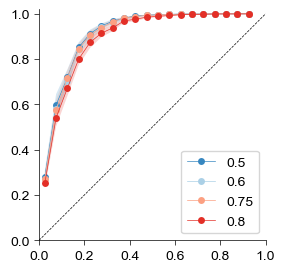

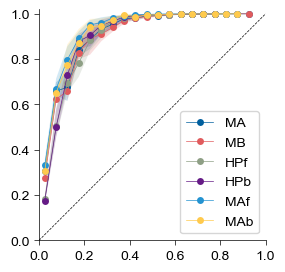

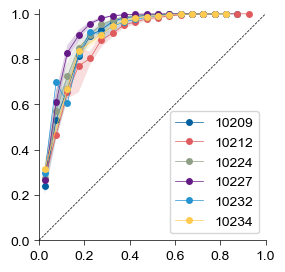

In [86]:
idx_real = np.where(CentroidDist['Type'] == 'Real')[0]
idx_nearby = np.where(CentroidDist['Type'] == 'Nearby')[0]

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
x = (CentroidDist['Cumulative Density'][idx_nearby] // 0.05) * 0.05 + 0.025
sns.lineplot(
    x=x,
    y=CentroidDist['Cumulative Density'][idx_real],
    hue=CentroidDist['Threshold'][idx_real],
    palette=sns.color_palette("Blues", 2)[::-1]+sns.color_palette("Reds", 2),
    ax=ax,
    linewidth=0.5,
    marker='o',
    markersize=5,
    markeredgewidth=0,
    err_kws={'edgecolor': None}
)
ax.axis([0, 1, 0, 1.02])
ax.set_aspect('equal')
ax.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.savefig(join(loc, "ROC Curve [Threshold].png"), dpi=600)
plt.savefig(join(loc, "ROC Curve [Threshold].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(CentroidDist, CentroidDist.keys(), np.where((CentroidDist['Threshold'] == 0.75))[0])
idx_real = np.where(SubData['Type'] == 'Real')[0]
idx_nearby = np.where(SubData['Type'] == 'Nearby')[0]
x = (SubData['Cumulative Density'][idx_nearby] // 0.05) * 0.05 + 0.025
sns.lineplot(
    x=x,
    y=SubData['Cumulative Density'][idx_real],
    hue=SubData['Paradigm'][idx_real],
    palette=['#005f9e', '#e05b5d', '#8E9F85', '#651b86', '#2493d1', '#ffca4d'],
    ax=ax,
    linewidth=0.5,
    marker='o',
    markersize=5,
    markeredgewidth=0,
    err_kws={'edgecolor': None}
)
ax.axis([0, 1, 0, 1.02])
ax.set_aspect('equal')
ax.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.savefig(join(loc, "ROC Curve [Paradigm].png"), dpi=600)
plt.savefig(join(loc, "ROC Curve [Paradigm].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(CentroidDist, CentroidDist.keys(), np.where((CentroidDist['Threshold'] == 0.75))[0])
idx_real = np.where(SubData['Type'] == 'Real')[0]
idx_nearby = np.where(SubData['Type'] == 'Nearby')[0]
x = (SubData['Cumulative Density'][idx_nearby] // 0.05) * 0.05 + 0.025
sns.lineplot(
    x=x,
    y=SubData['Cumulative Density'][idx_real],
    hue=SubData['MiceID'][idx_real],
    palette=['#005f9e', '#e05b5d', '#8E9F85', '#651b86', '#2493d1', '#ffca4d'],
    ax=ax,
    linewidth=0.5,
    marker='o',
    markersize=5,
    markeredgewidth=0,
    err_kws={'edgecolor': None}
)
ax.axis([0, 1, 0, 1.02])
ax.set_aspect('equal')
ax.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.savefig(join(loc, "ROC Curve [MiceID].png"), dpi=600)
plt.savefig(join(loc, "ROC Curve [MiceID].svg"), dpi=600)
plt.show()